# Self-borrowing activity

This notebook intends to study the self-borrowing activity within Compound V2. 

In [155]:
import altair as alt
alt.data_transformers.disable_max_rows()
import pandas as pd
import numpy as np
import statsmodels.api as sm
from datetime import datetime

Data from 19/08/2021 to 31/07/2023 have been collected. 

We will be interested in four variables:

- `SelfBorrowShare`:  The percentage of borrowed asset from self-borrow transactions within each pool.
- `priceUSD`:  The price of COMP tokens.
- `TVL`: The total value locked within Compound V2.
- `supply`: The number of COMP tokens in circulation. 

In [156]:
startDate = pd.to_datetime('2021-08-19')
endDate = pd.to_datetime('2023-12-31')

## SelfBorrowshare

In [157]:
liability_matrix = pd.read_csv('../data/balance_sheets/daily_liability_matrix.csv')
liability_matrix = liability_matrix.rename(columns={'date': 'timestamp'})
liability_matrix['timestamp'] = pd.to_datetime(liability_matrix['timestamp'])
liability_matrix.drop(['account', 'effectiveUSD'], axis=1, inplace=True)
liability_matrix = liability_matrix[liability_matrix['timestamp'].between(startDate, endDate)]

In [158]:
selfBorrow = liability_matrix[liability_matrix['symbol_bor'] == liability_matrix['symbol_col']]
selfBorrow = selfBorrow.groupby('timestamp').sum().drop(['symbol_col', 'symbol_bor'], axis=1).reset_index()
selfBorrow = selfBorrow.rename(columns={'matchBorrowUSD': 'selfBorrowUSD', 'matchCollateralUSD': 'selfCollateralUSD'})
selfBorrow

,timestamp,selfBorrowUSD,selfCollateralUSD
0,2021-08-19,5.416844e+09,7.598608e+09
1,2021-08-20,5.411134e+09,7.590484e+09
2,2021-08-21,5.430208e+09,7.604733e+09
3,2021-08-22,5.400847e+09,7.575981e+09
4,2021-08-23,5.333646e+09,7.491634e+09
...,...,...,...
860,2023-12-27,6.026538e+07,9.481195e+07
861,2023-12-28,6.347551e+07,1.005184e+08
862,2023-12-29,6.236249e+07,9.874706e+07
863,2023-12-30,6.067519e+07,9.608713e+07


In [159]:
totalBorrow = liability_matrix.groupby('timestamp').sum().drop(['symbol_bor', 'symbol_col'], axis=1).reset_index()
totalBorrow = totalBorrow.rename(columns={'matchBorrowUSD': 'totalBorrowUSD', 'matchCollateralUSD': 'totalCollateralUSD'})
totalBorrow

,timestamp,totalBorrowUSD,totalCollateralUSD
0,2021-08-19,7.914928e+09,1.444673e+10
1,2021-08-20,8.025064e+09,1.487075e+10
2,2021-08-21,8.088935e+09,1.506277e+10
3,2021-08-22,8.091316e+09,1.503731e+10
4,2021-08-23,8.139425e+09,1.519342e+10
...,...,...,...
860,2023-12-27,4.479141e+08,1.156537e+09
861,2023-12-28,4.386121e+08,1.121863e+09
862,2023-12-29,4.380012e+08,1.096472e+09
863,2023-12-30,4.366821e+08,1.100737e+09


In [160]:
matrix = selfBorrow.merge(totalBorrow, on='timestamp')
matrix['selfBorrowShare'] = matrix['selfBorrowUSD'] / matrix['totalBorrowUSD']
matrix['selfCollateralShare'] = matrix['selfCollateralUSD'] / matrix['totalCollateralUSD']
matrix.drop(['selfBorrowUSD', 'totalBorrowUSD', 'totalCollateralUSD', 'selfCollateralUSD'], axis=1, inplace=True)
matrix

,timestamp,selfBorrowShare,selfCollateralShare
0,2021-08-19,0.684383,0.525974
1,2021-08-20,0.674279,0.510431
2,2021-08-21,0.671313,0.504869
3,2021-08-22,0.667487,0.503812
4,2021-08-23,0.655285,0.493084
...,...,...,...
860,2023-12-27,0.134547,0.081979
861,2023-12-28,0.144719,0.089600
862,2023-12-29,0.142380,0.090059
863,2023-12-30,0.138946,0.087293


In [161]:
alt.Chart(matrix).mark_line().encode(
    x='timestamp:T',
    y='selfBorrowShare:Q'
).interactive(bind_y = False)

alt.Chart(...)

## priceUSD

In [162]:
price = pd.read_csv('../data/COMP_USD.csv', sep=';')
price = price[['timestamp', 'close']]
price['timestamp'] = price['timestamp'].apply(lambda date: datetime.strptime(date, '%Y-%m-%dT%H:%M:%S.%fZ'))
price['timestamp'] = price['timestamp'].dt.strftime('%Y-%m-%d')
price['timestamp'] = pd.to_datetime(price['timestamp'])
price = price.rename(columns={'close': 'priceUSD'})
price = price[price['timestamp'].between(startDate, endDate)]
price

,timestamp,priceUSD
39,2023-12-31,57.349371
40,2023-12-30,58.484663
41,2023-12-29,59.832476
42,2023-12-28,62.183714
43,2023-12-27,63.790147
...,...,...
899,2021-08-23,465.558598
900,2021-08-22,460.365323
901,2021-08-21,462.325055
902,2021-08-20,480.044869


In [163]:
matrix = matrix.merge(price, on='timestamp')
matrix

,timestamp,selfBorrowShare,selfCollateralShare,priceUSD
0,2021-08-19,0.684383,0.525974,457.666976
1,2021-08-20,0.674279,0.510431,480.044869
2,2021-08-21,0.671313,0.504869,462.325055
3,2021-08-22,0.667487,0.503812,460.365323
4,2021-08-23,0.655285,0.493084,465.558598
...,...,...,...,...
860,2023-12-27,0.134547,0.081979,63.790147
861,2023-12-28,0.144719,0.089600,62.183714
862,2023-12-29,0.142380,0.090059,59.832476
863,2023-12-30,0.138946,0.087293,58.484663


In [164]:
alt.Chart(matrix).mark_line().encode(
    x='timestamp:T',
    y='priceUSD:Q'
).interactive(bind_y = False)

alt.Chart(...)

## TVL

In [165]:
import json

json_file = '../data/daily_TVL.json'

with open(json_file, 'r') as f:
    data = json.load(f)

tvl = []
for entry in data['tvl']:
    tvl.append({'TVL': entry['totalLiquidityUSD']})

tvl = pd.DataFrame(tvl)
end_date = pd.to_datetime('2024-02-28')
start_date = end_date - pd.Timedelta(days=len(tvl) - 1)
tvl['timestamp'] = pd.date_range(start=start_date, end=end_date, freq='D')

tvl = tvl[tvl['timestamp'].between(startDate, endDate)].reset_index(drop=True)

tvl

,TVL,timestamp
0,1.037066e+10,2021-08-19
1,1.024546e+10,2021-08-20
2,1.025178e+10,2021-08-21
3,1.029383e+10,2021-08-22
4,1.014308e+10,2021-08-23
...,...,...
860,2.362075e+09,2023-12-27
861,2.326332e+09,2023-12-28
862,2.284811e+09,2023-12-29
863,2.277441e+09,2023-12-30


In [166]:
matrix = matrix.merge(tvl, on='timestamp')
matrix

,timestamp,selfBorrowShare,selfCollateralShare,priceUSD,TVL
0,2021-08-19,0.684383,0.525974,457.666976,1.037066e+10
1,2021-08-20,0.674279,0.510431,480.044869,1.024546e+10
2,2021-08-21,0.671313,0.504869,462.325055,1.025178e+10
3,2021-08-22,0.667487,0.503812,460.365323,1.029383e+10
4,2021-08-23,0.655285,0.493084,465.558598,1.014308e+10
...,...,...,...,...,...
860,2023-12-27,0.134547,0.081979,63.790147,2.362075e+09
861,2023-12-28,0.144719,0.089600,62.183714,2.326332e+09
862,2023-12-29,0.142380,0.090059,59.832476,2.284811e+09
863,2023-12-30,0.138946,0.087293,58.484663,2.277441e+09


In [167]:
alt.Chart(matrix).mark_line().encode(
    x='timestamp:T',
    y='TVL:Q'
).interactive(bind_y = False)

alt.Chart(...)

## Liquidity supply

In [168]:
marketCap = pd.read_csv('../data/COMP_coinmarketcap.csv', sep=';')
marketCap['supply'] = marketCap['marketCap']/marketCap['close']
marketCap['timestamp'] = marketCap['timestamp'].apply(lambda date: datetime.strptime(date, '%Y-%m-%dT%H:%M:%S.%fZ'))
marketCap['timestamp'] = pd.to_datetime(marketCap['timestamp'])
df = pd.DataFrame({'timestamp': pd.date_range(start='2020-09-12', end=endDate, freq='D')})
marketCap = marketCap.merge(df, on='timestamp', how='right')
marketCap = marketCap.ffill()
marketCap

,name,open,high,low,close,volume,marketCap,timestamp,supply
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-09-12,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-09-13,NaN
2,2790.0,139.159098,143.469660,119.069244,122.192578,7.338406e+08,3.132463e+08,2020-09-14,2.563546e+06
3,2790.0,139.159098,143.469660,119.069244,122.192578,7.338406e+08,3.132463e+08,2020-09-15,2.563546e+06
4,2790.0,139.159098,143.469660,119.069244,122.192578,7.338406e+08,3.132463e+08,2020-09-16,2.563546e+06
...,...,...,...,...,...,...,...,...,...
1201,2790.0,51.793879,61.388847,51.093531,51.957956,4.317690e+08,4.195992e+08,2023-12-27,8.075746e+06
1202,2790.0,51.793879,61.388847,51.093531,51.957956,4.317690e+08,4.195992e+08,2023-12-28,8.075746e+06
1203,2790.0,51.793879,61.388847,51.093531,51.957956,4.317690e+08,4.195992e+08,2023-12-29,8.075746e+06
1204,2790.0,51.793879,61.388847,51.093531,51.957956,4.317690e+08,4.195992e+08,2023-12-30,8.075746e+06


In [169]:
matrix = matrix.merge(marketCap[['supply', 'timestamp']], on='timestamp', how='left')
matrix = matrix.ffill()
matrix.dropna(inplace=True)
matrix

,timestamp,selfBorrowShare,selfCollateralShare,priceUSD,TVL,supply
0,2021-08-19,0.684383,0.525974,457.666976,1.037066e+10,5.438009e+06
1,2021-08-20,0.674279,0.510431,480.044869,1.024546e+10,5.438009e+06
2,2021-08-21,0.671313,0.504869,462.325055,1.025178e+10,5.438009e+06
3,2021-08-22,0.667487,0.503812,460.365323,1.029383e+10,5.438009e+06
4,2021-08-23,0.655285,0.493084,465.558598,1.014308e+10,5.537965e+06
...,...,...,...,...,...,...
860,2023-12-27,0.134547,0.081979,63.790147,2.362075e+09,8.075746e+06
861,2023-12-28,0.144719,0.089600,62.183714,2.326332e+09,8.075746e+06
862,2023-12-29,0.142380,0.090059,59.832476,2.284811e+09,8.075746e+06
863,2023-12-30,0.138946,0.087293,58.484663,2.277441e+09,8.075746e+06


# Time series Analysis

First, we are going to plot the different variables.

In [170]:
Y  = matrix['selfBorrowShare']
dY = (Y - Y.shift(1)).dropna()
X1 = matrix['priceUSD']
dX1 = (X1 - X1.shift(1)).dropna()
X2 = matrix['TVL']
dX2 = (X2 - X2.shift(1)).dropna()
X3 = matrix['supply']
dX3 = (X3 - X3.shift(1)).dropna()

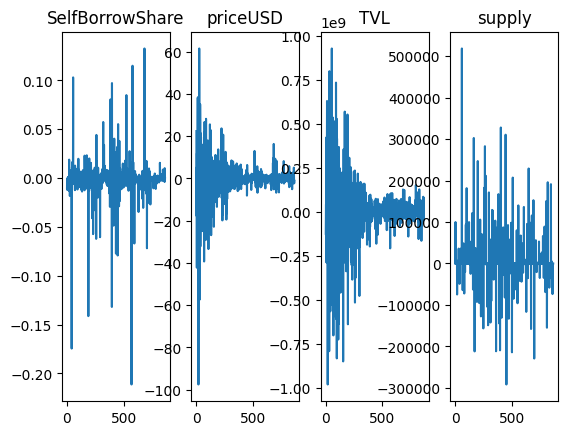

In [171]:
import matplotlib.pyplot as plt 

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=False)
ax1.plot(dY)
ax1.set_title('SelfBorrowShare')
ax2.plot(dX1)
ax2.set_title('priceUSD')
ax3.plot(dX2)
ax3.set_title('TVL')
ax4.plot(dX3)
ax4.set_title('supply')
plt.show()

Let's check stationarity and cointegration assumptions to choose the proper model. 

In [172]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen

We will be using an ADF test to check the unit root hypothesis.

In [173]:
def adf_test(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [174]:
print("ADF Test for SelfBorrowshare:")
adf_test(dY)

print("\nADF Test for priceUSD:")
adf_test(dX1)

print("\nADF Test for TVL:")
adf_test(dX2)

print("\nADF Test for supply:")
adf_test(dX3)

ADF Test for SelfBorrowshare:
ADF Statistic: -28.86491460847958
p-value: 0.0
Critical Values:
	1%: -3.438
	5%: -2.865
	10%: -2.569

ADF Test for priceUSD:
ADF Statistic: -6.12817596485043
p-value: 8.528269392363877e-08
Critical Values:
	1%: -3.438
	5%: -2.865
	10%: -2.569

ADF Test for TVL:
ADF Statistic: -5.074529049637876
p-value: 1.577001295176364e-05
Critical Values:
	1%: -3.438
	5%: -2.865
	10%: -2.569

ADF Test for supply:
ADF Statistic: -15.28476458507079
p-value: 4.52680770099505e-28
Critical Values:
	1%: -3.438
	5%: -2.865
	10%: -2.569


From the past result, we can assume that $ \Delta Y_t, \Delta X1_t,\Delta X2_t, \Delta X3_t$ are stationnary at a significant level.

Now let's check the cointegration assumption.

In [175]:
def johansen_test(data):
    result = coint_johansen(data, det_order=0, k_ar_diff=1)
    print("Eigenvalues:", result.eig)
    print("Trace Statistic:", result.lr1)
    print("Critical Values (Trace):", result.cvt)
    print("Maximum Eigenvalue Statistic:", result.lr2)
    print("Critical Values (Maximum Eigenvalue):", result.cvm)

In [176]:
data_for_cointegration = pd.concat([dY, dX1, dX2, dX3], axis=1)

print("\nJohansen Cointegration Test:")
johansen_test(data_for_cointegration)


Johansen Cointegration Test:
Eigenvalues: [0.50065922 0.34175019 0.34032941 0.29498153]
Trace Statistic: [1618.99393153 1020.36381495  659.90061254  301.29596176]
Critical Values (Trace): [[44.4929 47.8545 54.6815]
 [27.0669 29.7961 35.4628]
 [13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]
Maximum Eigenvalue Statistic: [598.63011658 360.46320241 358.60465079 301.29596176]
Critical Values (Maximum Eigenvalue): [[25.1236 27.5858 32.7172]
 [18.8928 21.1314 25.865 ]
 [12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]]


Here we have an ambivalent result. Indeed, the eigenvalues are < 1 meaning there shouldn't be cointegration however the Johansen Cointegration Test tells the contrary. From our perspective, the variables are cointegrated. We are  going to use the VECM model in an attempt to explain the $ \Delta Y $ variable

In [177]:
from statsmodels.tsa.vector_ar.vecm import select_order

stationary_data = pd.concat([dY, dX1, dX2, dX3], axis=1)

model_order = select_order(stationary_data, maxlags=10 )
model_order.summary()

/home/ukaz/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/ukaz/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/ukaz/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/ukaz/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/ukaz/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. 

,AIC,BIC,FPE,HQIC
0,55.01,55.12*,7.766e+23,55.05*
1,55.00,55.20,7.705e+23,55.08
2,55.02,55.31,7.867e+23,55.13
3,55.04,55.42,8.022e+23,55.19
4,55.06,55.53,8.167e+23,55.24
5,55.04,55.59,7.988e+23,55.25
6,54.93*,55.58,7.194e+23*,55.18
7,54.95,55.68,7.303e+23,55.23
8,54.96,55.78,7.382e+23,55.27
9,54.98,55.90,7.582e+23,55.33


In [178]:
from statsmodels.tsa.vector_ar.vecm import VECM

# Fit the auto_reg model with the optimal lag order
vecm_model = VECM(stationary_data, k_ar_diff=model_order.aic)
vecm_result = vecm_model.fit()

# Print the summary of the VECM model
vecm_result.summary()

/home/ukaz/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


,coef,std err,z,P>|z|,[0.025,0.975]
L1.selfBorrowShare,-0.7622,0.041,-18.613,0.000,-0.842,-0.682
L1.priceUSD,-0.0003,0.000,-1.824,0.068,-0.001,2.16e-05
L1.TVL,9.351e-12,4.27e-12,2.190,0.029,9.83e-13,1.77e-11
L1.supply,-1.068e-07,2.92e-08,-3.654,0.000,-1.64e-07,-4.95e-08
L2.selfBorrowShare,-0.6418,0.047,-13.564,0.000,-0.735,-0.549
L2.priceUSD,-0.0003,0.000,-1.561,0.118,-0.001,6.82e-05
L2.TVL,4.516e-12,6.29e-12,0.717,0.473,-7.82e-12,1.69e-11
L2.supply,-1.049e-07,2.72e-08,-3.859,0.000,-1.58e-07,-5.16e-08
L3.selfBorrowShare,-0.4983,0.050,-10.015,0.000,-0.596,-0.401
L3.priceUSD,-0.0002,0.000,-1.024,0.306,-0.001,0.000


In [179]:
predictions = pd.DataFrame(vecm_result.fittedvalues, columns = ['selfBorrowShare', 'priceUSD', 'TVL', 'supply'])
predictions


,selfBorrowShare,priceUSD,TVL,supply
0,-0.008425,5.821435,1.416824e+08,-2711.250767
1,-0.004188,-8.122613,-7.706552e+04,37151.730531
2,-0.004062,-14.479196,1.326795e+07,51903.926227
3,-0.003747,-2.596304,2.006453e+08,-13032.240282
4,0.000055,10.935976,-4.853113e+07,20443.694850
...,...,...,...,...
852,0.000692,4.282725,2.610983e+07,-12661.770716
853,-0.002739,0.416220,-9.950883e+06,-9324.620655
854,0.000312,0.804865,7.157918e+06,-9950.428049
855,-0.001364,1.336847,-2.547192e+07,-5422.202880


In [181]:
predictions['ref'] = dY[7:]
predictions['residuals'] = (predictions['ref'] - predictions['selfBorrowShare'])**2
predictions['date'] = pd.date_range(start='2021-08-27', end='2023-12-31', freq='D')
predictions.dropna(inplace=True)

In [ ]:
chart1 = alt.Chart(predictions).mark_line().encode(
    x = 'date:T',
    y = 'selfBorrowShare:Q',
    tooltip=['date:T', 'predicted:Q'],
    color=alt.value('black')
).properties(
    width=600,
    height=300
).interactive()

chart2 = alt.Chart(predictions).mark_line().encode(
    x = 'date:T',
    y = 'ref:Q',
    tooltip=['date:T', 'ref:Q'],
    color=alt.value('orange')
).properties(
    width=600,
    height=300
).interactive()

(chart1 +chart2).properties(title = "Predicted (black) VS real selfBorrowShare (orange)")

alt.LayerChart(...)

In [182]:
chart = alt.Chart(predictions).mark_line().encode(
    x = 'date:T',
    y = 'residuals:Q',
    tooltip=['date:T', 'predicted:Q'],
    color=alt.value('black')
).properties(
    width=600,
    height=300
).interactive()

chart.properties(title = "Residuals")

alt.Chart(...)

In [183]:
s = 0.684383
result =  []
for value in predictions['selfBorrowShare']:
     s +=  value
     result.append(s)
predictions['toSee'] =  result

chart1 = alt.Chart(predictions).mark_line().encode(
    x='date:T',
    y='toSee:Q',
    color=alt.value('black')
).interactive(bind_y = False)

chart2 = alt.Chart(matrix).mark_line().encode(
    x='timestamp:T',
    y='selfBorrowShare:Q',
    color=alt.value('orange')
).interactive(bind_y = False)

(chart1+chart2)

alt.LayerChart(...)